<a href="https://www.kaggle.com/code/zeyadalmothafar/arabic-company-reviews-sentiment-analysis?scriptVersionId=130198920" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Arabic Data Sentiment Analysis

* Analysis on multiple Arabic companies reviews like Talabat,Nestle,TelecomEgypt
* EDA then trying multiple MLclassification models and ROBERTA transformer for the sentiment prediction

> ***Please Upvote if you like the notebook***

<div style='color: #0D4564;
           background-color: #878c94;
           font-size: 200%;
           border-radius:15px;
           margin-top: 5px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Import Libraries
<a class="anchor" id="1"></a> 

In [1]:
!pip install pyarabic
!pip install bert-for-tf2
!pip install sentencepiece
!pip install emoji==1.7.0
!pip install Arabic-Stopwords
#!git clone https://github.com/aub-mind/arabert.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=154c3a2547ea87212453c74ad75fd2da0d93f1129bc00632703aa7c09e805ee3
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=3c8a954fb00d725931d5e13939f7fd5baba00eb82ed715045d15643f0a3a7483
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=81a9063f78234ec89df964930227b4832e5a99cd2e8226952549e025488b275d
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22

In [2]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",50)
from sklearn import preprocessing
import matplotlib as mpl
mpl.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score


from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb

import gensim
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


import tensorflow_hub as hub

try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]
import pyarabic.araby as ar


import functools, operator

import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

In [3]:
import arabicstopwords.arabicstopwords as stp
from nltk.stem.isri import ISRIStemmer
import re
import string,emoji

<div style='color: #0D4564;
           background-color: #878c94;
           font-size: 200%;
           border-radius:15px;
           margin-top: 5px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Preprocessing
<a class="anchor" id="1"></a> 

In [4]:
data = pd.read_csv("/kaggle/input/arabic-company-reviews/CompanyReviews.csv")
data.head()

,Unnamed: 0,review_description,rating,company
0,0,رائع,1,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,1,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,-1,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,-1,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,-1,talbat


In [5]:
data.rating.value_counts()

 1    23921
-1    14200
 0     1925
Name: rating, dtype: int64

**Mapping Ratings to Text**

In [6]:
ratingsDict = {1: 'Positive',
0: 'Neutral',
-1: 'Negative'}

In [7]:
data['rating'] = data['rating'].apply(lambda x: ratingsDict[x])

In [8]:
data.head()

,Unnamed: 0,review_description,rating,company
0,0,رائع,Positive,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,Positive,talbat
2,2,التطبيق لا يغتح دائما بيعطيني لا يوجد اتصال با...,Negative,talbat
3,3,لماذا لا يمكننا طلب من ماكدونالدز؟,Negative,talbat
4,4,البرنامج بيظهر كل المطاعم و مغلقه مع انها بتكو...,Negative,talbat


**Making a copy of the original data**

In [9]:
 origData = data.copy()

In [10]:
data['review_description'] =  data['review_description'].astype('str')

In [11]:
def data_preprocessing (data_frame):
    # clean-up: remove #tags, http links and special symbols
   
    data_frame['review_description']= data_frame['review_description'].apply(lambda x: re.sub(r'http\S+', '', x))
    data_frame['review_description'] = data_frame['review_description'].apply(lambda x: re.sub(r'[@|#]\S*', '', x))
    data_frame['review_description'] = data_frame['review_description'].apply(lambda x: re.sub(r'"+', '', x))

    # Remove signs
    data_frame['review_description'] = data_frame['review_description'].apply(lambda x: re.sub(r'([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+', '', x))

    # Remove repeated letters like "الللللللللللللللله" to "الله"
    data_frame['review_description'] = data_frame['review_description'].apply(lambda x: x[0:2] + ''.join([x[i] for i in range(2, len(x)) if x[i]!=x[i-1] or x[i]!=x[i-2]]))

    # remove stop words
    data_frame['review_description'] = data_frame['review_description'].apply(lambda x: '' if x in stp.stopwords_list() else x)

    #Stemming
    data_frame['review_description']= data_frame['review_description'].apply(lambda x:ISRIStemmer().stem(x))

    return data_frame

In [12]:
def data_cleaning (text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub("(\s\d+)","",text)
    text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
    text = re.sub("\d+", " ", text)
    text = ar.strip_tashkeel(text)
    text = ar.strip_tatweel(text)
    text = text.replace("#", " ");
    text = text.replace("@", " ");
    text = text.replace("_", " ");
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = re.sub(r'(.)\1+', r'\1', text)

    return text

In [13]:
data['review_description']= data['review_description'].apply(lambda x: data_cleaning(x))
data = data_preprocessing(data)

In [14]:
data.head(20)

,Unnamed: 0,review_description,rating,company
0,0,رئع,Positive,talbat
1,1,برنامج رائع جدا يساعد على تلبيه الاحتياجات بشك...,Positive,talbat
2,2,تطبيق لا يغتح دائما بيعطيني لا يوجد اتصال بالش...,Negative,talbat
3,3,لماذا لا يمكنا طلب من ماكدونالدز,Negative,talbat
4,4,برنامج بيظهر كل المطاعم و مغلقه مع انها بتكون ...,Negative,talbat
5,5,اصبح غالي جدا,Negative,talbat
6,6,جميل جدا رائع,Positive,talbat
7,7,لأسف الواحد ينصدم بعد زيادة الاسعار و لاسف بعض...,Negative,talbat
8,8,برنامج توترز توصيل احلى من برنامجكم فاشل,Negative,talbat
9,9,كتير في تحسن خدمة العملاء لطفين في بعض الاخطاء...,Positive,talbat


<div style='color: #0D4564;
           background-color: #878c94;
           font-size: 200%;
           border-radius:15px;
           margin-top: 5px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
EDA
<a class="anchor" id="1"></a> 

# All Companies ratings count and percentage

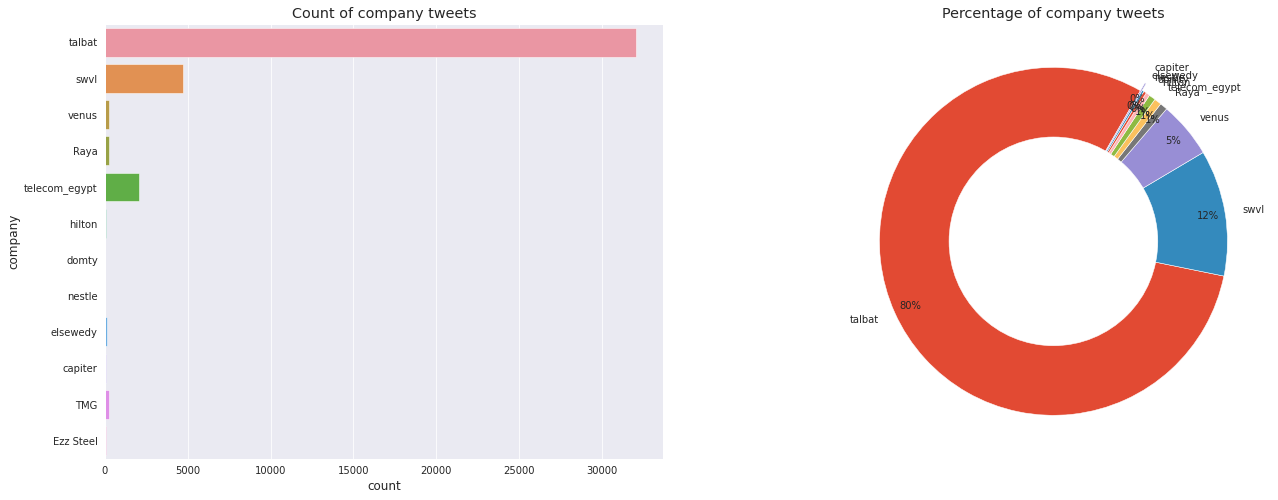

In [15]:
col = 'company'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
explode = list((np.array(list(data[col].dropna().value_counts()))/sum(list(data[col].dropna().value_counts())))[::-1])[:10]
labels = list(data[col].dropna().unique())[:10]
sizes = data[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = data, ax=ax1)
ax1.set_title("Count of company tweets")
ax2.set_title("Percentage of company tweets")
plt.show()

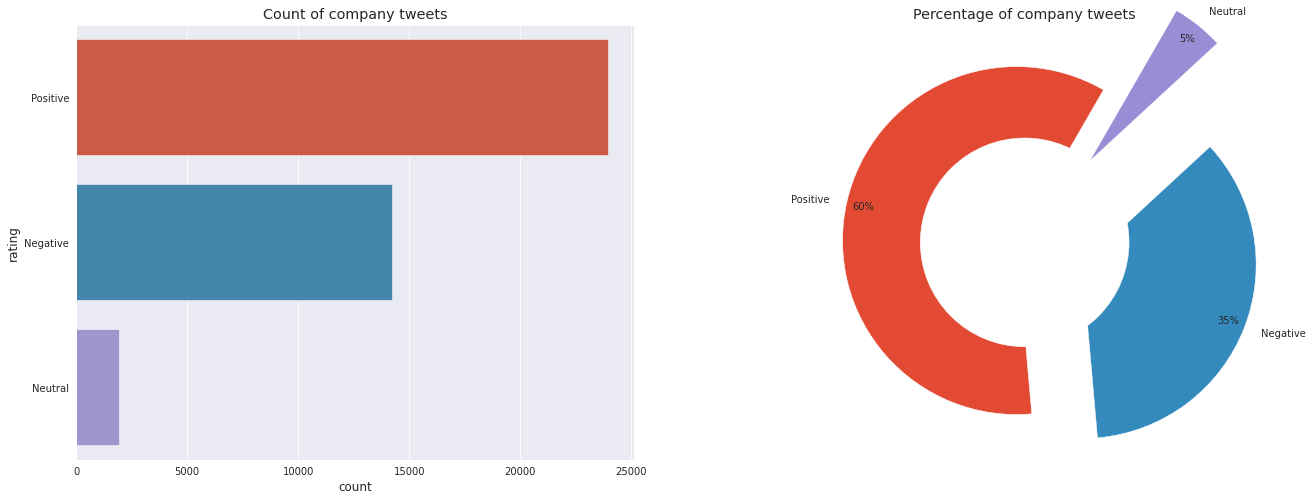

In [16]:
col = 'rating'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
explode = list((np.array(list(data[col].dropna().value_counts()))/sum(list(data[col].dropna().value_counts())))[::-1])[:10]
labels = list(data[col].dropna().unique())[:10]
sizes = data[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = data, ax=ax1)
ax1.set_title("Count of company tweets")
ax2.set_title("Percentage of company tweets")
plt.show()

# Talabat Ratings Count and Percentage

In [17]:
talabat = data[data["company"]== 'talbat']

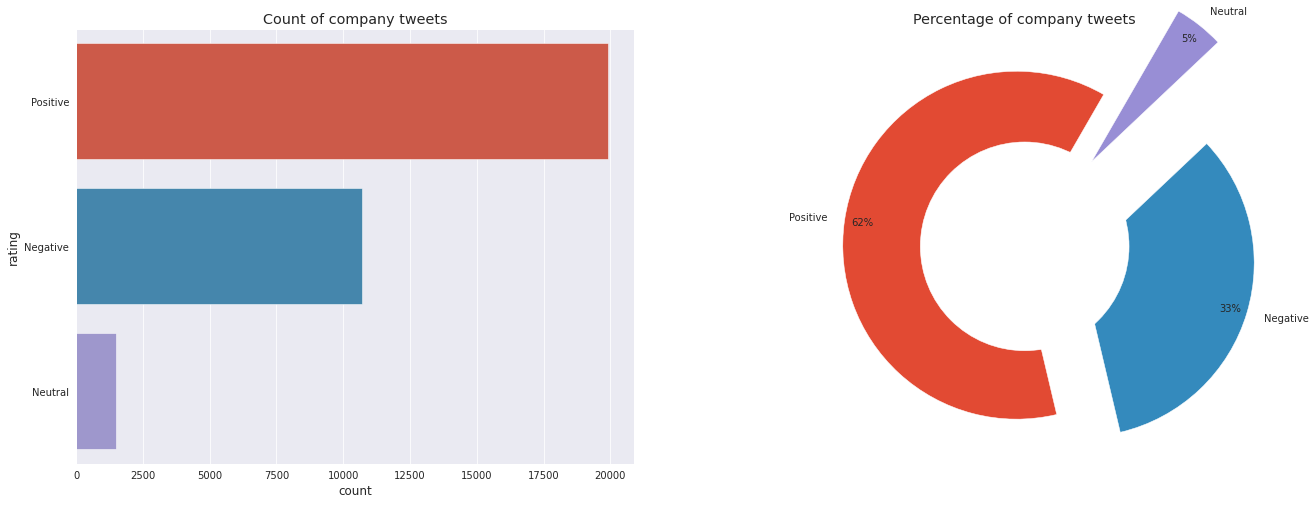

In [18]:
col = 'rating'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
explode = list((np.array(list(talabat[col].dropna().value_counts()))/sum(list(talabat[col].dropna().value_counts())))[::-1])[:10]
labels = list(talabat[col].dropna().unique())[:10]
sizes = talabat[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = talabat, ax=ax1)
ax1.set_title("Count of company tweets")
ax2.set_title("Percentage of company tweets")
plt.show()

**Splitting data**

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation=train_test_split(data['review_description'], data['rating'], test_size=0.3, random_state = 412)
X_validation

34340    انا معايا عربيه ملاكي وكنت محتاج اشغلها معاكم ...
28543    صراحه التطبيق عجبني كويس واله يحطو أشياء زي كذ...
31417                       روعه انصحكم انكم اتنزلونه روعه
9043                            حلو بس ساعات التوصيل يتاخر
24476                               خدمة وايد حلوه و مريحة
                               ...                        
16613    من أفضل برامج ومواقع التوصيل دقة فالطلب وسرعة ...
4091                                             وائل وائل
4671     لم يعد كما كان سابقا التطبيق أصبح سيء جدا والط...
6900     خدمة سيئة و عروض وهمية طلبت بأستخدام كود خصم و...
1649     تطبيق بجن ورائع وانصح به بقوه تنزلو كتير مدة ا...
Name: review_description, Length: 12014, dtype: object

<div style='color: #0D4564;
           background-color: #878c94;
           font-size: 200%;
           border-radius:15px;
           margin-top: 5px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Vectorization
<a class="anchor" id="1"></a> 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_ngram(n_gram,X_train,X_val):
    vectorizer = TfidfVectorizer(max_features = 30000, ngram_range=(n_gram,n_gram))
    x_train_vec = vectorizer.fit_transform(X_train)
    x_test_vec = vectorizer.transform(X_val)
    return x_train_vec,x_test_vec

In [21]:
tfidf_2g_transformation_train,tfidf_2g_transformation_validation= tfidf_ngram(2,X_train,X_validation)
tfidf_3g_transformation_train,tfidf_3g_transformation_validation= tfidf_ngram(3,X_train,X_validation)

In [22]:
print(tfidf_3g_transformation_train)

  (0, 12366)	1.0
  (1, 6363)	0.5773502691896257
  (1, 7227)	0.5773502691896257
  (1, 27531)	0.5773502691896257
  (3, 23189)	1.0
  (4, 28591)	0.49343294112873765
  (4, 1224)	0.4794372343564844
  (4, 11889)	0.5131587819192268
  (4, 4331)	0.5131587819192268
  (8, 2762)	0.22538755614643485
  (8, 18653)	0.24124034489540178
  (8, 3325)	0.1951580223668613
  (8, 2099)	0.17644265995380806
  (8, 7027)	0.24124034489540178
  (8, 833)	0.22028409806582813
  (8, 19484)	0.24124034489540178
  (8, 10346)	0.24124034489540178
  (8, 9642)	0.24124034489540178
  (8, 8441)	0.212588729121617
  (8, 12022)	0.24124034489540178
  (8, 12806)	0.24124034489540178
  (8, 515)	0.19843084451439125
  (8, 12612)	0.24124034489540178
  (8, 19387)	0.24124034489540178
  (8, 12325)	0.24124034489540178
  :	:
  (28018, 14590)	0.3400207961127833
  (28018, 21505)	0.3400207961127833
  (28018, 701)	0.31767678125337556
  (28018, 29472)	0.29963723087810445
  (28019, 16585)	0.7208253201698542
  (28019, 1442)	0.6931167706829976
  (28020,

In [23]:
tfidf_3g_transformation_train.shape

(28032, 30000)

# Dimensionality Reduction for both 2gram and 3gram data

In [24]:
from sklearn.decomposition import TruncatedSVD
  
truncatedSVD = TruncatedSVD(300)

In [25]:
X_train_2 = truncatedSVD.fit_transform(tfidf_2g_transformation_train)
X_test_2 = truncatedSVD.transform(tfidf_2g_transformation_validation)

In [26]:
X_train_3 = truncatedSVD.fit_transform(tfidf_3g_transformation_train)
X_test_3 = truncatedSVD.transform(tfidf_3g_transformation_validation)

In [27]:
X_train_2[2]

array([ 2.02614987e-05,  3.42512629e-06,  2.39614740e-05,  3.72624421e-05,
        1.20337080e-04,  1.56016698e-04,  7.90601972e-04,  3.59366724e-05,
        4.07182330e-03,  6.39925176e-05,  1.06730915e-04,  1.00325968e-04,
        2.06554053e-04,  4.51707137e-04,  2.81456586e-04,  1.17813829e-03,
        3.20008963e-04,  5.89841193e-04, -1.72585838e-05,  2.24917554e-05,
        4.12994267e-04, -1.52630192e-04, -1.67758534e-04,  5.70105020e-04,
        2.34777804e-03,  2.61347131e-02,  1.54732078e-02,  1.22293660e-03,
       -4.68862760e-04,  2.02095962e-04,  2.57676980e-04,  7.49883953e-04,
        1.21805946e-04,  7.57488416e-05, -1.41676760e-04, -1.33120030e-04,
        4.61761056e-04, -1.98851979e-03,  1.29932879e-03, -2.58707887e-04,
       -1.23783890e-03,  1.48023912e-03,  5.94032600e-04,  8.98194204e-04,
        5.88288685e-03,  1.44340603e-03,  1.69322621e-03,  1.06001537e-02,
       -1.71267252e-04,  3.00126991e-04, -4.85181127e-04,  4.27031927e-03,
        6.76142020e-03, -

<div style='color: #0D4564;
           background-color: #878c94;
           font-size: 200%;
           border-radius:15px;
           margin-top: 5px;
           text-align:center;
           font-weight:600;
           border-style: solid;
           border-color: dark green;
           font-family: "Verdana";'>
Modelling
<a class="anchor" id="1"></a> 

In [28]:
models=[SVC(),
        DecisionTreeClassifier(),
        GradientBoostingClassifier(n_estimators=300, random_state=10,max_features = "auto")]

# Running models on both 2gram and 3gram data

In [29]:
for m in models :
    print(m.__str__)
    m.fit(X_train_2,y_train)
    print('Accuracy on Train Data = ',m.score(X_train_2,y_train))
    print('Accuracy on Test Data = ',m.score(X_test_2,y_validation))

<method-wrapper '__str__' of SVC object at 0x79b663f2ef50>
Accuracy on Train Data =  0.7485017123287672
Accuracy on Test Data =  0.7284001997669386
<method-wrapper '__str__' of DecisionTreeClassifier object at 0x79b663f2e7d0>
Accuracy on Train Data =  0.9295804794520548
Accuracy on Test Data =  0.7020975528550025
<method-wrapper '__str__' of GradientBoostingClassifier object at 0x79b663f2e490>
Accuracy on Train Data =  0.8128210616438356
Accuracy on Test Data =  0.7676044614616281


**We can see there is Overfitting in the DecisionTree Classifier**

In [30]:
for m in models :
    print(m.__str__)
    m.fit(X_train_3,y_train)
    print('Accuracy on Train Data = ',m.score(X_train_3,y_train))
    print('Accuracy on Test Data = ',m.score(X_test_3,y_validation))

<method-wrapper '__str__' of SVC object at 0x79b663f2ef50>
Accuracy on Train Data =  0.6569634703196348
Accuracy on Test Data =  0.6428333610787414
<method-wrapper '__str__' of DecisionTreeClassifier object at 0x79b663f2e7d0>
Accuracy on Train Data =  0.8629780251141552
Accuracy on Test Data =  0.6537373064757782
<method-wrapper '__str__' of GradientBoostingClassifier object at 0x79b663f2e490>
Accuracy on Train Data =  0.7487157534246576
Accuracy on Test Data =  0.6715498584984185


**The best model to use till now is the Gradient boosting classifier with 2gram training data**

# Trying AdaBoost with Hyperparameter Tuning and CrossValidation

In [31]:
def modelfit(alg,performCV=True, cv_folds = 5):
    #Fit the algorithm on the data
    alg.fit(tfidf_2g_transformation_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(tfidf_2g_transformation_train)
    dtrain_predprob = alg.predict_proba(tfidf_2g_transformation_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validate(alg, tfidf_2g_transformation_train,y_train, cv=cv_folds, scoring='accuracy')
    
    accuracy = metrics.accuracy_score(np.array(y_train),np.array(dtrain_predictions))
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : \n" + f'{accuracy}')
    #print ("AUC Score (Train): %f" + f'{metrics.roc_auc_score(dtrain['Decision'], dtrain_predprob)})
    
    if performCV:
         print ("CV Score :" f'{cv_score}')
        

In [32]:
param_test = {'n_estimators':[100,300,500],"learning_rate" :[0.01,0.1]} 
model = AdaBoostClassifier()
gsearch = GridSearchCV(estimator = model, param_grid = param_test, scoring='accuracy') 
gsearch.fit(X_train_2,y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [33]:
modelfit(gsearch.best_estimator_)


Model Report
Accuracy : 
0.6795804794520548
CV Score :{'fit_time': array([249.8245399 , 250.11600375, 250.30036259, 253.7859385 ,
       254.61570334]), 'score_time': array([0.58822203, 0.59187222, 0.60239959, 0.58735347, 0.59150505]), 'test_score': array([0.67843767, 0.67362226, 0.67124509, 0.67142347, 0.67017481])}


**AdaBoost with hyperparameters didnt perform better than GradientBoosting Classifier**

# Arabic Multilingual Sentiment Classification ROBERTA 

In [34]:
from transformers import pipeline
import tokenizers
# this will download 2 GB
nlp = pipeline("sentiment-analysis", model='akhooli/xlm-r-large-arabic-sent')

Downloading:   0%|          | 0.00/730 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some weights of the model checkpoint at akhooli/xlm-r-large-arabic-sent were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [35]:
for i in range(50,71):
    print(data.iloc[i]["review_description"])
    print(nlp(data.iloc[i]["review_description"]))
    print("--------------------------------------")

بصراحة تغير كبير في سياسة طلبات مع الزبائن هناك تقدير لمستخدم طلبات بعكس الأوليتم التواصل بسرعة معنا وحل الموضوع و التعويض اذا حصل مشكلةلكن يجب مراجعة سعر التوصيل التطبيقات الثانية أقل سعر و أحيانا بدون سعر توصيل  شكرا طلبات 
[{'label': 'LABEL_0', 'score': 0.4236145615577698}]
--------------------------------------
تطبيق اصبح سيء جدا والتكلفة اصبحت مرتفعة كان التطبيق المفضل بنسبة لي وكنت اتصفحه واستخدمه يوميا لكن الان اصبح مخيب لامال
[{'label': 'LABEL_1', 'score': 0.9735539555549622}]
--------------------------------------
انا احب كل شي فيه
[{'label': 'LABEL_2', 'score': 0.954534113407135}]
--------------------------------------
ازبل واحقر واوسخ برنامج وموظفين وساخه ونصب مش طبيعي
[{'label': 'LABEL_1', 'score': 0.9251326322555542}]
--------------------------------------
جيد
[{'label': 'LABEL_2', 'score': 0.9994044303894043}]
--------------------------------------
ميز كثير 
[{'label': 'LABEL_2', 'score': 0.47312310338020325}]
--------------------------------------
لماذة لا استطيع استخدام

In [36]:
for i,v in enumerate(data.itertuples()):
    data.at[i,'Roberta Sentiment'] = nlp(data.iloc[i]["review_description"][:512])[0]['label']     

In [37]:
#Remember 2 is positive, 0 is negative and 1 is neutral
sentimentMap = {'LABEL_2' : 'Positive',
               'LABEL_1' : "Negative",
               'LABEL_0' : "Neutral",}

In [38]:
data['Roberta Sentiment'] = data['Roberta Sentiment'].apply(lambda x: sentimentMap[x])

In [39]:
def modelAccuracy():
    trueCount = 0
    for i,v in enumerate(data.itertuples()): 
        if data.at[i,'Roberta Sentiment'] == data.at[i,'rating']:
            trueCount +=1
    print('Accuracy = ', trueCount/data.shape[0])                
    

In [40]:
modelAccuracy()

Accuracy =  0.6531738500724167


# Looks like GradientBoosting Classifier is performing better than Roberta Sentiment model that we have here